### Ćwiczenia projektowe 2.
Anna Marjankowska, Adrian Żyła

In [82]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score
from IPython.display import Image
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

#### Wczytanie zestawu danych oraz obróbka.

In [83]:
data = pd.read_csv('./stroke_zaj2.csv', sep = ';', decimal = ',')
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [84]:
data.shape

(400, 11)

In [85]:
data['stroke'].value_counts()

1    200
0    200
Name: stroke, dtype: int64

In [86]:
data.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [87]:
data.isnull().sum()

gender                0
age                   0
hypertension          0
heart_disease         0
ever_married          0
work_type             0
Residence_type        0
avg_glucose_level     0
bmi                  37
smoking_status        0
stroke                0
dtype: int64

#### **Zadanie 1.**
**Scharakteryzować krótko wykorzystywane dane (czego dotyczą, jakiego rodzaju zmienne zawierają, jaki jest poziom zbalansowania zbioru danych). Wyeliminować braki danych.**


W zbiorze danych posiadamy zmienne dotyczące **stanu zdrowia**, **stylu życia** oraz **wieku**.  
Zmienne kategoryczne to **gender**, **ever_married**, **work_type**, **residence_type**, **smoking_status**. Pozostałe zmienne, to zmienne ilościowe. <br>
Zbiór danych jest **zbalansowany**, posiadamy $200$ obserwacji należących do klasy pozytywnej, jak i $200$ obserwacji należąych do klasy negatywnej. 
<br>
W danych występują **brakujące wartości** dla zmiennej **BMI**, dlatego zdecydowaliśmy się na ich usunięcie.*  
<br>
**Podczas ćwiczeń przetestowaliśmy modele na dwóch różnych zestawach danych: jednym z usuniętymi brakującymi wartościami oraz drugim, w którym brakujące dane zostały zastąpione średnią. Okazało się, że modele osiągały lepsze wyniki na danych, z których usunięto brakujące wartości.*
 

Przechodzimy więc do usunięcia z danych wierszych, w których brakuje danych dla zmiennej BMI.

In [88]:
data = data.dropna()

In [89]:
data.shape

(363, 11)

In [90]:
data['stroke'].value_counts()

0    193
1    170
Name: stroke, dtype: int64

Po wyeliminownaiu brakujących wartości, rozkład jest w miarę równomierny, około $47\%$ dla klasy pozytywnej i $53\%$ dla klasy negatywnej. Przy takiej różnicy uznajemy dane za wystarczająco zbalansowane.

W następnym kroku zamienimy zmienne kategoryczne na zmienne binarne, za pomocą **one-hot endoding**.

In [91]:
gender_dummies = pd.get_dummies(data['gender'], dtype = int, drop_first = True)
ever_married_dummies = pd.get_dummies(data['ever_married'], dtype = int, drop_first = True)
work_type_dummies = pd.get_dummies(data['work_type'], dtype = int, drop_first = True)
residence_type_dummies = pd.get_dummies(data['Residence_type'], dtype = int, drop_first = True)
smoking_status_dummies = pd.get_dummies(data['smoking_status'], dtype = int, drop_first = True)

In [92]:
data = pd.concat([gender_dummies, data[['age', 'hypertension', 'heart_disease']], ever_married_dummies, work_type_dummies, 
        residence_type_dummies, data[['avg_glucose_level', 'bmi',]], smoking_status_dummies, data[['stroke']]], axis = 1)
data = data.rename(columns = {'Yes': 'ever_married'})
data.head()

,Male,age,hypertension,heart_disease,ever_married,Never_worked,Private,Self-employed,children,Urban,avg_glucose_level,bmi,formerly smoked,never smoked,smokes,stroke
0,1,67.0,0,1,1,0,1,0,0,1,228.69,36.6,1,0,0,1
1,1,80.0,0,1,1,0,1,0,0,0,105.92,32.5,0,1,0,1
2,0,49.0,0,0,1,0,1,0,0,1,171.23,34.4,0,0,1,1
3,0,79.0,1,0,1,0,0,1,0,0,174.12,24.0,0,1,0,1
4,1,81.0,0,0,1,0,1,0,0,1,186.21,29.0,1,0,0,1


#### Budowa modelu - drzewa decyzyjne.

#### **Zadanie 2.**
**Wykorzystać proste drzewo decyzyjne do predykcji wartości zmiennej wynikowej. Zweryfikować jak poziom przycięcie drzewa wpływa na uzyskiwane wyniki (zarówno na zbiorze testowym, jak i uczącym). Zwrócić szczególną uwagę na miary: dokładności, czułości i specyficzności.**

Podział danych na zbiór uczący i testowy w proporcji $80/20$:

In [93]:
y = data.stroke
X = data.iloc[:, 0:15]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

Budowa modelu drzewa decyzyjnego z domyślnymi parametrami:

In [94]:
model_dc = DecisionTreeClassifier(random_state=42)
model_dc.fit(X_train, y_train)

y_pred_train = model_dc.predict(X_train)
y_pred_test = model_dc.predict(X_test)

Prezentacja wyników na zbiorze uczącym:


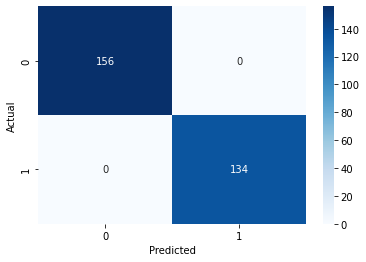

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       156
           1       1.00      1.00      1.00       134

    accuracy                           1.00       290
   macro avg       1.00      1.00      1.00       290
weighted avg       1.00      1.00      1.00       290

Dokładność modelu: 1.00
Czułość modelu: 1.00


In [95]:
print("Prezentacja wyników na zbiorze uczącym:")
conf_matrix = confusion_matrix(y_train, y_pred_train)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_train, y_pred_train))
print(f"Dokładność modelu: {accuracy_score(y_train, y_pred_train):0.2f}")
print(f"Czułość modelu: {recall_score(y_train, y_pred_train):0.2f}")

Prezentacja wyników na zbiorze testowym:


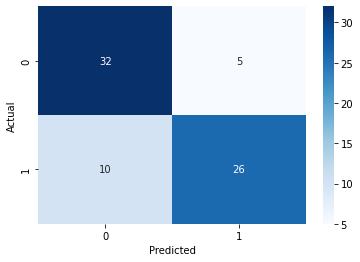

              precision    recall  f1-score   support

           0       0.76      0.86      0.81        37
           1       0.84      0.72      0.78        36

    accuracy                           0.79        73
   macro avg       0.80      0.79      0.79        73
weighted avg       0.80      0.79      0.79        73

Dokładność modelu: 0.79
Czułość modelu: 0.72


In [96]:
print("Prezentacja wyników na zbiorze testowym:")
conf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_test, y_pred_test))
print(f"Dokładność modelu: {accuracy_score(y_test, y_pred_test):0.2f}")
print(f"Czułość modelu: {recall_score(y_test, y_pred_test):0.2f}")

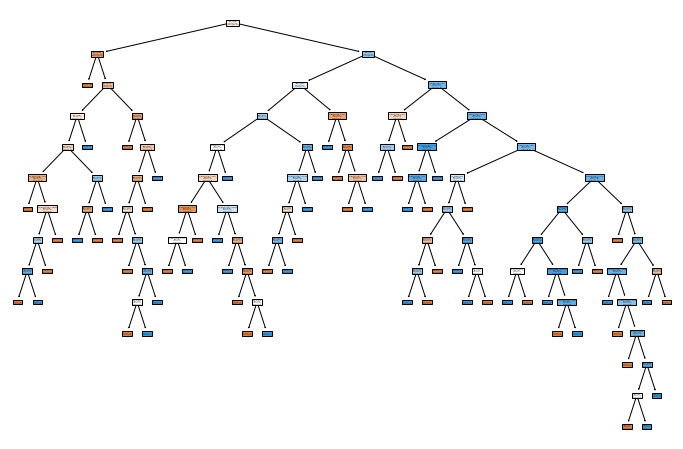

In [97]:
plt.figure(figsize=(12, 8))
plot_tree(model_dc, feature_names=X_train.columns, filled=True)
plt.show()

Na zbiorze uczącym otrzymaliśmy dokładność na poziomie $100\%$, natomiast na zbiorze testowym dokładność jest znacznie niższa. Może to świadczyć o nadmiernym **przeuczeniu modelu**.<br>
Na wizualizacji widzimy, że drzewo jest bardzo głębokie i szczegółowe, w efekcie czego może nadmiernie dopasowywać się do danych treningowych.

Zobaczmy teraz jak zadziała ustawienie parametrów - **max_depth** oraz **criterion**.

In [104]:
results = []
for i in tqdm(range(1, 20)):
    model_dt = DecisionTreeClassifier(max_depth=i)
    model_dt.fit(X_train, y_train)
    y_pred_test = model_dt.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    sensitivity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1])
    specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
    results.append([i, accuracy_test, sensitivity, specificity])
results = pd.DataFrame(results, columns=['max_depth', 'accuracy', 'recall', 'precision'])
results

100%|██████████| 19/19 [00:00<00:00, 58.87it/s]


,max_depth,accuracy,recall,precision
0,1,0.808219,0.805556,0.810811
1,2,0.808219,0.805556,0.810811
2,3,0.821918,0.805556,0.837838
3,4,0.821918,0.805556,0.837838
4,5,0.821918,0.805556,0.837838
5,6,0.808219,0.777778,0.837838
6,7,0.780822,0.777778,0.783784
7,8,0.794521,0.722222,0.864865
8,9,0.821918,0.750000,0.891892
9,10,0.808219,0.722222,0.891892


Analiza wyników przedstawionych w tabeli pokazuje, że dla drzewa decyzyjnego o maksymalnej głębokości w granicach $4$ uzyskano jednocześnie najwyższą dokładnoś oraz czułość.
 
Niższa złożoność modelu przekłada się na mniejszą podatność na przeuczenie, co pozwala mu lepiej generalizować na nowych danych. Dodatkowo, prostsze modele są łatwiejsze do interpretacji, co ułatwia zrozumienie reguł rządzących podejmowanymi decyzjami.

#### **Zadanie 3.** 
**Zastosować 2 z 3 możliwych rozszerzeń drzew decyzyjnych: las losowy, bagging, boosting. Zweryfikować, jak dobór hiperparametrów wpływa na wyniki. W przypadku rozszerzeń przeanalizować można np. zmiany:**
- **bagging: liczby drzew, liczby obserwacji, złożoności drzewa,**
- **las losowy: liczby drzew w lesie, liczby zmiennych, złożoności drzewa,**
- **boosting: liczby modeli do zbudowania.**

**Porównać wyniki z zadania 2 i 3.**



#### Budowa modelu - las losowy.
Budowa modelu dla domyślnych parametrów. 

In [105]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)

y_pred_train = model_rf.predict(X_train)
y_pred_test = model_rf.predict(X_test)

Prezentacja wyników na zbiorze uczącym:


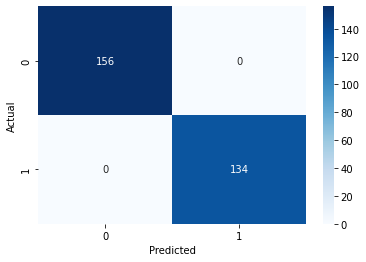

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       156
           1       1.00      1.00      1.00       134

    accuracy                           1.00       290
   macro avg       1.00      1.00      1.00       290
weighted avg       1.00      1.00      1.00       290

Dokładność modelu: 1.00
Czułość modelu: 1.00


In [106]:
print("Prezentacja wyników na zbiorze uczącym:")
conf_matrix = confusion_matrix(y_train, y_pred_train)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_train, y_pred_train))
print(f"Dokładność modelu: {accuracy_score(y_train, y_pred_train):0.2f}")
print(f"Czułość modelu: {recall_score(y_train, y_pred_train):0.2f}")

Prezentacja wyników na zbiorze testowym:


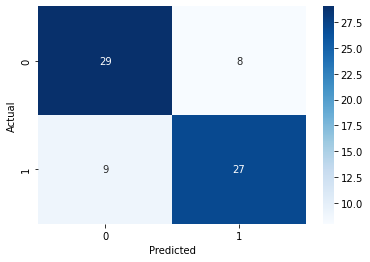

              precision    recall  f1-score   support

           0       0.76      0.78      0.77        37
           1       0.77      0.75      0.76        36

    accuracy                           0.77        73
   macro avg       0.77      0.77      0.77        73
weighted avg       0.77      0.77      0.77        73

Dokładność modelu: 0.77
Czułość modelu: 0.75


In [107]:
print("Prezentacja wyników na zbiorze testowym:")
conf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_test, y_pred_test))
print(f"Dokładność modelu: {accuracy_score(y_test, y_pred_test):0.2f}")
print(f"Czułość modelu: {recall_score(y_test, y_pred_test):0.2f}")

Dokładność na zbiorze treningowym to $100\%$, natomiast na zbiorze testowym jest zniacznie niższa, może to świadczyć o przeuczonym modelu. 

Spróbujemy teraz znależć parametry odpowiadające za maksymalną głębokość drzewa, liczbę drzew w lesie oraz kryterium podziału.

In [108]:
best_n_estimators = 0
best_max_depth = 0
best_accuracy = 0
best_model = None
for i in tqdm(range(1, 20)):
    for j in range(1, 20):
        model_rf = RandomForestClassifier(max_depth=j, n_estimators=i, random_state=42)
        model_rf.fit(X_train, y_train)
        y_pred_test = model_rf.predict(X_test)
        accuracy_test = accuracy_score(y_test, y_pred_test)
        if accuracy_test > best_accuracy:
            best_n_estimators = i
            best_max_depth = j
            best_accuracy = accuracy_test
            best_model = model_rf

100%|██████████| 19/19 [00:20<00:00,  1.10s/it]


In [109]:
print(f'Najlepsza liczba n_estimators: {best_n_estimators}')
print(f'Najlepsza wartość max_depth: {best_max_depth}')
print(f'Największa dokładność na zbiorze testowym: {best_accuracy:0.2f}')

Najlepsza liczba n_estimators: 15
Najlepsza wartość max_depth: 6
Największa dokładność na zbiorze testowym: 0.84


In [110]:
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

Prezentacja wyników na zbiorze uczącym:


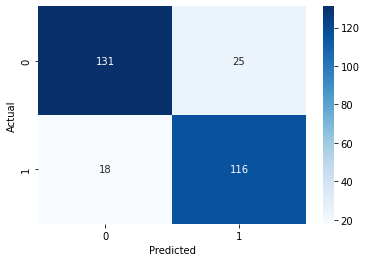

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       156
           1       0.82      0.87      0.84       134

    accuracy                           0.85       290
   macro avg       0.85      0.85      0.85       290
weighted avg       0.85      0.85      0.85       290

Dokładność modelu: 0.85
Czułość modelu: 0.87


In [111]:
print("Prezentacja wyników na zbiorze uczącym:")
conf_matrix = confusion_matrix(y_train, y_pred_train)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_train, y_pred_train))
print(f"Dokładność modelu: {accuracy_score(y_train, y_pred_train):0.2f}")
print(f"Czułość modelu: {recall_score(y_train, y_pred_train):0.2f}")

Prezentacja wyników na zbiorze testowym:


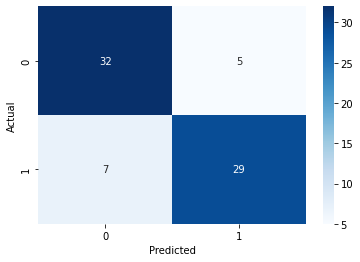

              precision    recall  f1-score   support

           0       0.82      0.86      0.84        37
           1       0.85      0.81      0.83        36

    accuracy                           0.84        73
   macro avg       0.84      0.84      0.84        73
weighted avg       0.84      0.84      0.84        73

Dokładność modelu: 0.84
Czułość modelu: 0.81


In [112]:
print("Prezentacja wyników na zbiorze testowym:")
conf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_test, y_pred_test))
print(f"Dokładność modelu: {accuracy_score(y_test, y_pred_test):0.2f}")
print(f"Czułość modelu: {recall_score(y_test, y_pred_test):0.2f}")

Jak widzimy, udało nam się uzyskać lepszą dokładność niż w przypadku lasów losowych z domyślnymi parametrami.

#### Budowa modelu - AdaBoost.

In [113]:
model_ab = AdaBoostClassifier(random_state=42)
model_ab.fit(X_train, y_train)

y_pred_train = model_ab.predict(X_train)
y_pred_test = model_ab.predict(X_test)

Prezentacja wyników na zbiorze uczącym:


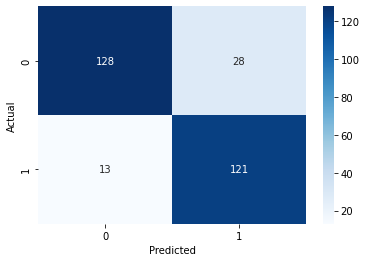

              precision    recall  f1-score   support

           0       0.91      0.82      0.86       156
           1       0.81      0.90      0.86       134

    accuracy                           0.86       290
   macro avg       0.86      0.86      0.86       290
weighted avg       0.86      0.86      0.86       290

Dokładność modelu: 0.86
Czułość modelu: 0.90


In [114]:
print("Prezentacja wyników na zbiorze uczącym:")
conf_matrix = confusion_matrix(y_train, y_pred_train)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_train, y_pred_train))
print(f"Dokładność modelu: {accuracy_score(y_train, y_pred_train):0.2f}")
print(f"Czułość modelu: {recall_score(y_train, y_pred_train):0.2f}")

Prezentacja wyników na zbiorze testowym:


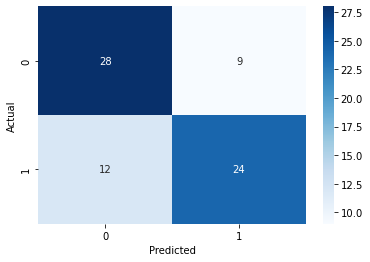

              precision    recall  f1-score   support

           0       0.70      0.76      0.73        37
           1       0.73      0.67      0.70        36

    accuracy                           0.71        73
   macro avg       0.71      0.71      0.71        73
weighted avg       0.71      0.71      0.71        73

Dokładność modelu: 0.71
Czułość modelu: 0.67


In [115]:
print("Prezentacja wyników na zbiorze testowym:")
conf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_test, y_pred_test))
print(f"Dokładność modelu: {accuracy_score(y_test, y_pred_test):0.2f}")
print(f"Czułość modelu: {recall_score(y_test, y_pred_test):0.2f}")

Poszukajmy najlepszych parametrów dla modelu AdaBoost.

In [116]:
best_n_estimators = 0
best_learning_rate = 0  
best_accuracy = 0
best_model_ada = None
for i in tqdm(range(1, 20)):
    for j in np.arange(0.1, 1.1, 0.1):
        model_ada = AdaBoostClassifier(n_estimators=i, learning_rate=j, random_state=42)
        model_ada.fit(X_train, y_train)
        y_pred_test = model_ada.predict(X_test)
        accuracy_test = accuracy_score(y_test, y_pred_test)
        if accuracy_test > best_accuracy:
            best_accuracy = accuracy_test
            best_n_estimators = i
            best_learning_rate = j
            best_model_ada = model_ada

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:08<00:00,  2.25it/s]


In [117]:
print(f'Najlepsza wartość n_estimators: {best_n_estimators}')
print(f'Najlepsze learning_rate: {best_learning_rate}')
print(f'Najwyższa dokładność: {best_accuracy:0.2f}')

Najlepsza wartość n_estimators: 1
Najlepsze learning_rate: 0.1
Najwyższa dokładność: 0.81


In [118]:
y_pred_train = best_model_ada.predict(X_train)
y_pred_test = best_model_ada.predict(X_test)

Prezentacja wyników na zbiorze uczącym:


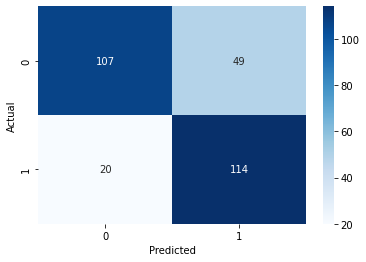

              precision    recall  f1-score   support

           0       0.84      0.69      0.76       156
           1       0.70      0.85      0.77       134

    accuracy                           0.76       290
   macro avg       0.77      0.77      0.76       290
weighted avg       0.78      0.76      0.76       290

Dokładność modelu: 0.76
Czułość modelu: 0.85


In [119]:
print("Prezentacja wyników na zbiorze uczącym:")
conf_matrix = confusion_matrix(y_train, y_pred_train)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_train, y_pred_train))
print(f"Dokładność modelu: {accuracy_score(y_train, y_pred_train):0.2f}")
print(f"Czułość modelu: {recall_score(y_train, y_pred_train):0.2f}")

Prezentacja wyników na zbiorze testowym:


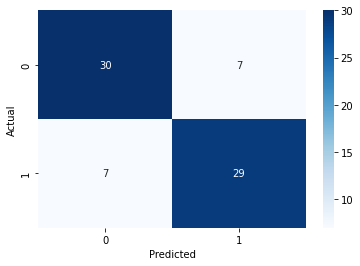

              precision    recall  f1-score   support

           0       0.81      0.81      0.81        37
           1       0.81      0.81      0.81        36

    accuracy                           0.81        73
   macro avg       0.81      0.81      0.81        73
weighted avg       0.81      0.81      0.81        73

Dokładność modelu: 0.81
Czułość modelu: 0.81


In [120]:
print("Prezentacja wyników na zbiorze testowym:")
conf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_test, y_pred_test))
print(f"Dokładność modelu: {accuracy_score(y_test, y_pred_test):0.2f}")
print(f"Czułość modelu: {recall_score(y_test, y_pred_test):0.2f}")

Po ustawieniu parametru odpowiedzialnego za liczbę modeli bazowych uzyskujemy lepszą dokładność oraz czułość niż w przypadku domyślnej wartości. Ustawiona przez nas wartość jest mniejsza od domyślnego $n\_estimators = 50$, przy której model mógł zostać przetrenowany, ze względu na stosunkowo nieduży zbiór danych. Dodatkowo dokładność na zbiorze testowym jest wyższa niż na zbiorze treningowym, co świadczy o tym, że model nie jest przeuoczny i dobrze sobie radzi z predykcją na niewidzianych dotąd danych.

#### Budowa modelu - bagging.

In [121]:
model_bagg = BaggingClassifier(random_state=42)
model_bagg.fit(X_train, y_train)

y_pred_train = model_bagg.predict(X_train)
y_pred_test = model_bagg.predict(X_test)

Prezentacja wyników na zbiorze uczącym:


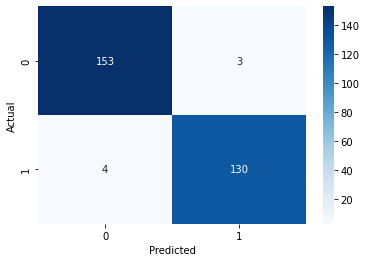

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       156
           1       0.98      0.97      0.97       134

    accuracy                           0.98       290
   macro avg       0.98      0.98      0.98       290
weighted avg       0.98      0.98      0.98       290

Dokładność modelu: 0.98
Czułość modelu: 0.97


In [122]:
print("Prezentacja wyników na zbiorze uczącym:")
conf_matrix = confusion_matrix(y_train, y_pred_train)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_train, y_pred_train))
print(f"Dokładność modelu: {accuracy_score(y_train, y_pred_train):0.2f}")
print(f"Czułość modelu: {recall_score(y_train, y_pred_train):0.2f}")

Prezentacja wyników na zbiorze testowym:


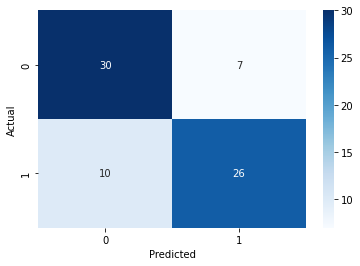

              precision    recall  f1-score   support

           0       0.75      0.81      0.78        37
           1       0.79      0.72      0.75        36

    accuracy                           0.77        73
   macro avg       0.77      0.77      0.77        73
weighted avg       0.77      0.77      0.77        73

Dokładność modelu: 0.77
Czułość modelu: 0.72


In [123]:
print("Prezentacja wyników na zbiorze testowym:")
conf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_test, y_pred_test))
print(f"Dokładność modelu: {accuracy_score(y_test, y_pred_test):0.2f}")
print(f"Czułość modelu: {recall_score(y_test, y_pred_test):0.2f}")

In [124]:
best_n_estimators = 0
best_accuracy = 0
best_model_bagg = None
for i in tqdm(range(1, 20)):
    model_bagg = BaggingClassifier(n_estimators=i, random_state=42)
    model_bagg.fit(X_train, y_train)
    y_pred_test = model_bagg.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    if accuracy_test > best_accuracy:
        best_accuracy = accuracy_test
        best_n_estimators = i
        best_model_bagg = model_bagg

100%|██████████| 19/19 [00:01<00:00, 15.55it/s]


In [125]:
print(f'Najlepsza wartość n_estimators: {best_n_estimators}')
print(f'Najwyższa dokładność: {best_accuracy:0.2f}')

Najlepsza wartość n_estimators: 13
Najwyższa dokładność: 0.81


In [126]:
y_pred_train = best_model_bagg.predict(X_train)
y_pred_test = best_model_bagg.predict(X_test)

Prezentacja wyników na zbiorze uczącym:


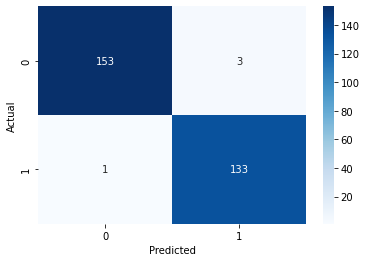

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       156
           1       0.98      0.99      0.99       134

    accuracy                           0.99       290
   macro avg       0.99      0.99      0.99       290
weighted avg       0.99      0.99      0.99       290

Dokładność modelu: 0.99
Czułość modelu: 0.99


In [127]:
print("Prezentacja wyników na zbiorze uczącym:")
conf_matrix = confusion_matrix(y_train, y_pred_train)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_train, y_pred_train))
print(f"Dokładność modelu: {accuracy_score(y_train, y_pred_train):0.2f}")
print(f"Czułość modelu: {recall_score(y_train, y_pred_train):0.2f}")

Prezentacja wyników na zbiorze testowym:


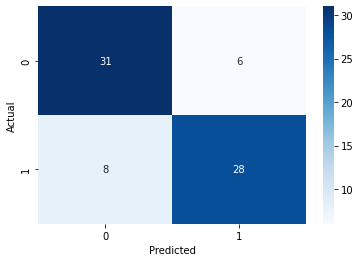

              precision    recall  f1-score   support

           0       0.79      0.84      0.82        37
           1       0.82      0.78      0.80        36

    accuracy                           0.81        73
   macro avg       0.81      0.81      0.81        73
weighted avg       0.81      0.81      0.81        73

Dokładność modelu: 0.81
Czułość modelu: 0.78


In [128]:
print("Prezentacja wyników na zbiorze testowym:")
conf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_test, y_pred_test))
print(f"Dokładność modelu: {accuracy_score(y_test, y_pred_test):0.2f}")
print(f"Czułość modelu: {recall_score(y_test, y_pred_test):0.2f}")

Pomimo ustalenia hiperparametru, dokładność oraz czułość na zbiorze treningowym nieznacznie się poprawiły. Dokładność na zbiorze uczącym jest bardzo wysoka, co może wskazywać na przeuczenie modelu. Bagging, może być nieodpowiednim modelem, dla naszego zbioru danych. 

#### **Zadanie 4.** 
**Wykorzystać algorytm SVM do predykcji wartości zmiennej wynikowej (UWAGA: w metodzie tej zalecana jest standaryzacja danych). Zbudować modele wykorzystujące:**
- **jądro liniowe (linear),**
- **jądro wielomianowe (poly),**
- **jądro radialne (rbf - radial basis function).**

**W każdym przypadku przyjąć domyśle wartości pozostałych hiperparametrów. Zinterpretować wyniki.**

#### Budowa modelu - SVM.

Do algorytmu SVM wskazane jest przeprowadzenie standaryzacji danych. Tak jak w przypadku drzew, usuniemy wiersze zawierające braki zmiennej **BMI** oraz zamienimy zmienne kategoryczne na zmienne binarne.

In [129]:
data = pd.read_csv('./stroke_zaj2.csv', sep = ';', decimal = ',')
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [130]:
data = data.dropna()

In [131]:
gender_dummies = pd.get_dummies(data['gender'], dtype = int, drop_first = True)
ever_married_dummies = pd.get_dummies(data['ever_married'], dtype = int, drop_first = True)
work_type_dummies = pd.get_dummies(data['work_type'], dtype = int, drop_first = True)
residence_type_dummies = pd.get_dummies(data['Residence_type'], dtype = int, drop_first = True)
smoking_status_dummies = pd.get_dummies(data['smoking_status'], dtype = int, drop_first = True)

In [132]:
data = pd.concat([gender_dummies, data[['age', 'hypertension', 'heart_disease']], ever_married_dummies, work_type_dummies, 
        residence_type_dummies, data[['avg_glucose_level', 'bmi',]], smoking_status_dummies, data[['stroke']]], axis = 1)
data = data.rename(columns = {'Yes': 'ever_married'})
data.head()

,Male,age,hypertension,heart_disease,ever_married,Never_worked,Private,Self-employed,children,Urban,avg_glucose_level,bmi,formerly smoked,never smoked,smokes,stroke
0,1,67.0,0,1,1,0,1,0,0,1,228.69,36.6,1,0,0,1
1,1,80.0,0,1,1,0,1,0,0,0,105.92,32.5,0,1,0,1
2,0,49.0,0,0,1,0,1,0,0,1,171.23,34.4,0,0,1,1
3,0,79.0,1,0,1,0,0,1,0,0,174.12,24.0,0,1,0,1
4,1,81.0,0,0,1,0,1,0,0,1,186.21,29.0,1,0,0,1


In [133]:
data.shape

(363, 16)

Podział na zbiór uczący oraz testowy:

In [134]:
X = data.iloc[:, 0:15]
y = data.stroke
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

Standaryzacja danych, aby model był mniej obciążony obliczeniowo:

In [135]:
scaler = StandardScaler()
X_train[['age', 'avg_glucose_level', 'bmi']] = scaler.fit_transform(X_train[['age', 'avg_glucose_level', 'bmi']])
X_test[['age', 'avg_glucose_level', 'bmi']] = scaler.transform(X_test[['age', 'avg_glucose_level', 'bmi']])

SVM - budowa modelu:

In [73]:
kernels = ['linear', 'poly', 'rbf']
results = []
for kernel in kernels:
    model_SVM = SVC(kernel=kernel)
    model_SVM.fit(X_train, y_train)
    y_pred_train = model_SVM.predict(X_train)
    y_pred_test = model_SVM.predict(X_test)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    recall_train = recall_score(y_train, y_pred_train)
    recall_test = recall_score(y_test, y_pred_test)
    results.append([accuracy_train, accuracy_test, recall_train, recall_test])
results = pd.DataFrame(results, index=kernels, columns=['accuracy_train', 'accuracy_test', 'recall_train', 'recall_test'])
results

,accuracy_train,accuracy_test,recall_train,recall_test
linear,0.803150,0.770642,0.818966,0.796296
poly,0.877953,0.715596,0.836207,0.666667
rbf,0.830709,0.743119,0.862069,0.796296


Dla naszego zbioru danych najlepsze wyniki daje nam model **SVM z jądrem liniowym**. Porównując dokładność na zbiorze treningowym jak i testowym możemy wyciagnąć wnioski, że pozostałe modele zostały **przetrenowane**. Ich dokładność dla danych treningowych była stosunkowo wysoka, natomiast dla danych testowych snacznie spadała. W przypadku jądra liniowego dokładość dla danych treningowych jest najniższa ze wszystkich modeli, a dla danych testowych najwyższa, równa $74\%$. Dokładność na zbiorze treningowym jest wyższa niż na zbiorze testowym, co również może świadczyć o przeuczeniu modelu.

Spróbujmy teraz dobrać pozostałe parametry dla modelu SVM.

In [74]:
C_values = [0.1, 1, 10, 100, 1000]
kernels = ['linear', 'poly', 'rbf']
results = []
best_SVM = None
for kernel in kernels:
    for C in C_values:
        model_SVM = SVC(kernel=kernel, C=C)
        model_SVM.fit(X_train, y_train)
        y_pred_train = model_SVM.predict(X_train)
        y_pred_test = model_SVM.predict(X_test)
        accuracy_train = accuracy_score(y_train, y_pred_train)
        accuracy_test = accuracy_score(y_test, y_pred_test)
        results.append([kernel, C, accuracy_train, accuracy_test])
        if accuracy_test == max([res[3] for res in results]):
            best_SVM = model_SVM
results = pd.DataFrame(results, columns=['kernel', 'C', 'accuracy_train', 'accuracy_test'])
results

,kernel,C,accuracy_train,accuracy_test
0,linear,0.1,0.795276,0.761468
1,linear,1.0,0.803150,0.770642
2,linear,10.0,0.791339,0.761468
3,linear,100.0,0.795276,0.761468
4,linear,1000.0,0.795276,0.761468
5,poly,0.1,0.814961,0.715596
6,poly,1.0,0.877953,0.715596
7,poly,10.0,0.933071,0.651376
8,poly,100.0,0.992126,0.642202
9,poly,1000.0,1.000000,0.642202


W przypadku jądra liniowego jak i wielomianowego najlepsze wyniki uzyskujemy dla $C$ równego $1$, a  wartości są bardzo zbliżone do siebie, model jest więc mało czuły na hiperparamter $C$. Może to oznaczać, że nasze dane są stosunkowo proste i **dobrze rozdzielone liniowo**.<br>
W przypadku jądra rbf, najlepsze wyniki są dla $C = 0.1$.

Aby zrozumieć, jak różne parametry wpływają na wyniki modelu SVM, przeprowadzamy przeszukiwanie siatki hiperparametrów za pomocą GridSearchCV. Definiujemy zestaw parametrów do przetestowania, aby znaleźć kombinację, która zapewnia najlepsze wyniki na danych treningowych.
 
Testowane parametry:
1. **C** (0.1, 1, 10, 100, 1000):  
   - Parametr $C$ wpływa na funckję celu podczas optymalizacji modelu SVM. Wartość $C$ nadaje karę za błędy w klasyfikacji. Odpowiada za regularyzację modelu. Mniejsza wartość $C$ sprzyja lepszemu generalizowaniu modelu, ale może zwiększyć błąd na danych treningowych, podczas gdy większe wartości pozwalają na bardziej dokładne dopasowanie, ponieważ model dąży do najmniejszej liczby błędów klasyfikacji, co zwiększa ryzyko przeuczenia. 
 
2. **kernel** (linear, poly, rbf):  
   - Określa funkcję jądra, która przekształca dane wejściowe w wyższy wymiar.  
     - linear: Zakłada liniową separację danych.  
     - poly: Wielomianowe jądro, które pozwala uchwycić bardziej złożone wzorce w danych.  
     - rbf: Jądro radialne, skuteczne dla nieliniowo separowalnych danych.  
 
3. **degree** (2, 3, 4, 5):  
   - Parametr specyficzny dla jądra poly, który określa stopień wielomianu.  
   - Większe wartości pozwalają uchwycić bardziej złożone zależności, ale mogą prowadzić do przeuczenia.
 
4. **gamma** (scale, auto):  
   - Steruje zasięgiem wpływu pojedynczego przykładu w przestrzeni cech.  
     - scale: Automatycznie dostosowuje wartość na podstawie liczby cech.  
     - auto: Zakłada odwrotność liczby cech.  
 

In [75]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear', 'poly', 'rbf'], 'degree': [2, 3, 4, 5], 'gamma': ['scale', 'auto']}
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid.fit(X_train, y_train)
grid.best_params_

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..........C=0.1, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ..........C=0.1, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ..........C=0.1, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ..........C=0.1, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ..........C=0.1, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.1, degree=2, gamma=sca

{'C': 1, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}

Uzyskane optymalne parametry:
- **C: 1** – model jest umiarkowanie elastyczny, co zapewnia równowagę między dopasowaniem do danych a generalizacją.
- **degree: 2** – oznacza stopień wielomianu dla jądra wielomianowego.
- **gamma: auto** – automatyczne skalowanie gamma dobrze dopasowuje model do liczby cech w zbiorze danych.
- **kernel: poly** – dane są najlepiej separowalne za pomocą prostego jądra wielomianowego.

In [79]:
y_pred_train = grid.predict(X_train)
y_pred_test = grid.predict(X_test)
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

print(f"Dokładność dla zbioru treningowego: {accuracy_train:0.2f}")
print(f"Dokładność dla zbioru testowego: {accuracy_test:0.2f}")

Dokładność dla zbioru treningowego: 0.80
Dokładność dla zbioru testowego: 0.73
